# 0. 사용할 패키지 불러오기

In [1]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.layers.core import Flatten
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.models import load_model
import cv2


# 1. 데이터 불러오기

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [3]:
import numpy as np
import glob
import sys
from sklearn.model_selection import train_test_split

x_train = np.empty((0, 180, 240, 3))
y_train = np.empty((0, 3))
print(y_train.shape)

training_data = glob.glob('/home/pirl/Desktop/1216Image2NPZ/*.npz')

x_train = []
cnt_data={0:0,1:0,2:0}
for single_npz in training_data:
    with np.load(single_npz) as data:
        #print(data.files)
        x = data['train']
        try :
            y = data['trining_label']

        except KeyError :  # 에러 종류
            y = data['training_label']
        print(x.shape)
        '''for i in range(x.shape[0]):
            tmp = x[i]
            temp=cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY) # convert color to gray
            x = np.reshape(temp, ( -1, 180, 240, 1))
            
            x_train = np.vstack((x_train, x))'''
        
        temp_list = []
        print("x.shape is ",x.shape)
        for i in x:
            #print(i.shape)
#           temp=cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
            temp_list.append(np.reshape(i, (180, 240, 3)))
            y_train = np.vstack((y_train, y))   
            cnt_data[np.argmax(y)]+=1

        x_train.extend(temp_list)
        
x_train = np.array(x_train)        
print(x_train.shape)
print(y_train.shape)
# train test split, 7:3
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state = 42)

y_train = y_train[:,:]
y_test = y_test[:,:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(0, 3)
(9022, 240, 180, 3)
x.shape is  (9022, 240, 180, 3)
(9042, 240, 180, 3)
x.shape is  (9042, 240, 180, 3)
(18064, 180, 240, 3)
(18064, 3)
(12644, 180, 240, 3) (12644, 3)
(5420, 180, 240, 3) (5420, 3)


In [4]:
cnt_data

{0: 0, 1: 9042, 2: 9022}

# 데이터 확인

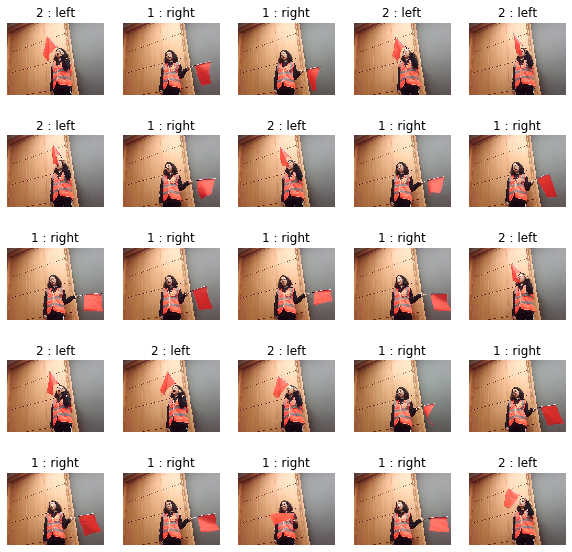

In [5]:
# 데이터 확인
from matplotlib import pyplot as plt
import random
%matplotlib inline

plt_row = 5
plt_col = 5
plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)
idx = random.sample(range(x_train.shape[0]), 25)

for i in range(plt_row*plt_col):

    sub_plt = axarr[int(i/plt_row), int(i%plt_col)]
    sub_plt.axis('off')
    #sub_plt.imshow(x_train[i].reshape(180, 240,3))
    sub_plt.imshow(x_train[idx[i]].reshape(180,240,3))
    #label = np.argmax(y_train[i])
    label = np.argmax(y_train[idx[i]])                 
    if label == 2 :
        direction = 'left'
    elif label == 1:
        direction = 'right'
    elif label == 0:
        direction = 'forward'
                      
    sub_plt_title = str(label) + " : " + direction
    sub_plt.set_title(sub_plt_title)

plt.show()

# 3. 모델 생성

In [6]:
# image size = 160 x 320
def posla_net():
    
    # model setting
    H = 180
    W = 240
    CH = 3


    inputShape = (H, W, CH)

    activation = 'relu'
    keep_prob_conv = 0.25
    keep_prob_dense = 0.5

    #init = 'glorot_normal'
    #init = 'he_normal'
    init = 'he_uniform'
    chanDim = -1
    classes = 3
    
    model = Sequential()
    
    # CONV => RELU => POOL
    model.add(Conv2D(3, (3, 3), padding="valid", input_shape=inputShape, kernel_initializer=init, activation=activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(9, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(18, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(80, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    model.add(Dense(15, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    # softmax classifier
    model.add(Dense(classes , activation = 'softmax'))
    
    return model

In [7]:
model = posla_net()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 238, 3)       84        
_________________________________________________________________
batch_normalization (BatchNo (None, 178, 238, 3)       12        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 119, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 117, 9)        252       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 58, 9)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 56, 18)        1476      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 28, 18)        0         
__________

In [63]:
# from tensorflow.python.keras.utils import plot_model
# plot_model(model, to_file= 'video_net_plot.png', show_shapes = True, show_layer_names = True)

# 4. 모델 파라미터 셋팅

적은 수의 이미지 데이터가 존재할 경우 데이터를 늘리는 용도로 사용

In [8]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [11]:
# initialize the model
# EPOCHS = 50
# INIT_LR = 1e-3
# BS = 32
# split_ratio = 0.2

In [12]:
EPOCHS = 10
INIT_LR = 1e-3
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
 

[INFO] compiling model...


# 5. 모델 훈련

In [13]:
from tensorflow.keras.utils import to_categorical


In [14]:
y_binary = to_categorical(y_train)

In [15]:
hist = model.fit(x_train, y_train, 
                 epochs=EPOCHS, batch_size=BS, 
                 validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Train on 10115 samples, validate on 2529 samples
Epoch 1/10
10115/10115 [==============================] - 17s 2ms/step - loss: 1.5622 - acc: 0.6985 - val_loss: 0.1976 - val_acc: 1.0000
Epoch 2/10
10115/10115 [==============================] - 12s 1ms/step - loss: 0.3789 - acc: 0.8860 - val_loss: 0.0423 - val_acc: 1.0000
Epoch 3/10
10115/10115 [==============================] - 12s 1ms/step - loss: 0.2502 - acc: 0.9289 - val_loss: 0.0122 - val_acc: 1.0000
Epoch 4/10
10115/10115 [==============================] - 12s 1ms/step - loss: 0.1888 - acc: 0.9543 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 5/10
10115/10115 [==============================] - 12s 1ms/step - loss: 0.1657 - acc: 0.9629 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 6/10
10115/10115 [==============================] - 12s 1ms/step - loss: 0.1448 - acc: 0.9692 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 7/10
10115/10115 [==============================] - 12s 1ms/step - loss: 0.1338 - acc: 0.9741 - val_loss: 1.2056e-04 - val_

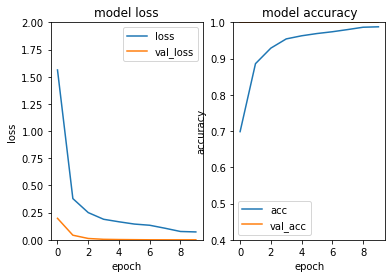

In [16]:
plt.subplot(1, 2, 1)
plt.title('model loss')

plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0,2))

plt.subplot(1, 2, 2)
plt.title('model accuracy')
plt.plot(hist.history['acc'], label="acc")
plt.plot(hist.history['val_acc'], label="val_acc")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0.4, 1))


plt.show();

# 6. 모델 결과 확인

In [25]:
#l_model = load_model('./model_data/VGG_model.h5')

In [17]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

5420/5420 [==============================] - 4s 827us/step
## evaluation loss and_metrics ##
[1.2093585897007442e-07, 1.0]


In [18]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 1, Predict : 1
True : 2, Predict : 2
True : 1, Predict : 1
True : 2, Predict : 2
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 2, Predict : 2


# 7. 최종 모델 훈련

In [19]:
x_total = np.vstack((x_train, x_test))
y_total = np.vstack((y_train, y_test))

print(x_total.shape)
print(y_total.shape)

(18064, 180, 240, 3)
(18064, 3)


In [20]:
early_stopping = EarlyStopping(monitor='loss', patience=10)

In [21]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [22]:
EPOCHS = 10
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [23]:
hist = model.fit(x_total, y_total, 
                 epochs=EPOCHS, batch_size=BS, 
                 #validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Epoch 1/10
18064/18064 [==============================] - 19s 1ms/step - loss: 0.0609 - acc: 0.9900
Epoch 2/10
18064/18064 [==============================] - 18s 1ms/step - loss: 0.0574 - acc: 0.9905
Epoch 3/10
18064/18064 [==============================] - 18s 1ms/step - loss: 0.0574 - acc: 0.9908
Epoch 4/10
18064/18064 [==============================] - 18s 1ms/step - loss: 0.0532 - acc: 0.9905
Epoch 5/10
18064/18064 [==============================] - 19s 1ms/step - loss: 0.0495 - acc: 0.9928
Epoch 6/10
18064/18064 [==============================] - 19s 1ms/step - loss: 0.0488 - acc: 0.9923
Epoch 7/10
18064/18064 [==============================] - 19s 1ms/step - loss: 0.0482 - acc: 0.9916
Epoch 8/10
18064/18064 [==============================] - 19s 1ms/step - loss: 0.0434 - acc: 0.9927
Epoch 9/10
18064/18064 [==============================] - 19s 1ms/step - loss: 0.0453 - acc: 0.9925
Epoch 10/10
18064/18064 [==============================] - 19s 1ms/step - loss: 0.0411 - acc: 0.9941

In [24]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

5420/5420 [==============================] - 5s 869us/step
## evaluation loss and_metrics ##
[1.1920930376163597e-07, 1.0]


In [25]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 1, Predict : 1
True : 2, Predict : 2
True : 2, Predict : 2
True : 1, Predict : 1
True : 2, Predict : 2
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 2, Predict : 2


# 8. 모델 저장

In [35]:
#model.save('./model_data/video_model_3.h5')

In [26]:
from tensorflow.python.keras.models import model_from_yaml

model_yaml = model.to_yaml()
with open("mm_v7.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("mm_v7.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# 저장만 안했습니당!